In [18]:
# @title Setup

competition = "Level 2: liver-fibrosis"  # @param
# @markdown ---

from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

competition_name = "liver-fibrosis-severity-prediction"

! kaggle competitions download -c {competition_name}
! unzip /content/{competition_name}.zip
! rm -rf {competition_name}.zip

User cancelled operation
unzip:  cannot find or open /content/liver-fibrosis-severity-prediction.zip, /content/liver-fibrosis-severity-prediction.zip.zip or /content/liver-fibrosis-severity-prediction.zip.ZIP.


In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from tqdm import tqdm
from PIL import Image, ImageEnhance

from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Overview

In [5]:
train_df = pd.read_csv('/content/liver-fibrosis-severity-prediction/train.csv')
train_df.rename(columns={'SWE fibrosis stage': 'stage'}, inplace=True)
train_df['stage'] = train_df['stage'].apply(lambda x: x.replace(' ', ''))

print(train_df.shape)
train_df.head()

(1772, 6)


,subject,image_name,view,stage,TE(kPa),TE result
0,1,5c7e1166e138234adf000b5a,Intercostal,-,3.4,F0
1,2,5c809dc9e138233fae00064d,Intercostal,-,8.5,F2
2,3,5cedf3f5e13823798c000355,Subcostal_hepatic_vein,F2,9.4,F3
3,3,5cedf408e13823798c00035e,Intercostal,F2,9.4,F3
4,3,5cedf40ce13823798c000364,Liver/RK,F2,9.4,F3


## Preprocess

In [37]:
!mkdir processed-image

images_dir = '/content/liver-fibrosis-severity-prediction/images/images'
image_files = np.sort([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])

mkdir: cannot create directory ‘processed-image’: File exists


Filename: 5c809dc9e138233fae00064d.png
Fibrosis stage: F2


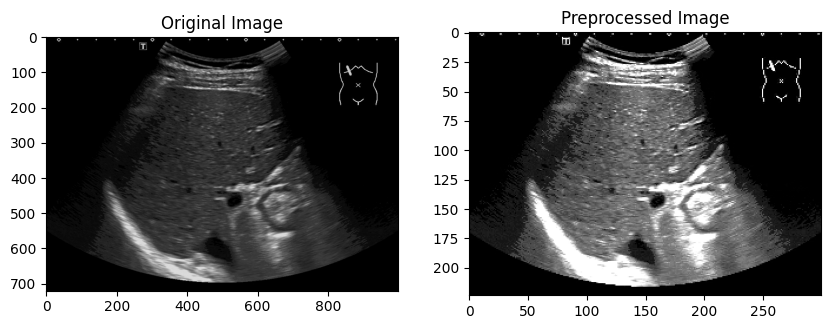

In [44]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(blurred_img)

    # Edge Enhancement (using unsharp masking-like approach)
    # Subtract blurred image from original to get details, then add back
    details = cv2.subtract(img, blurred_img)
    enhanced_img = cv2.addWeighted(img, 1.0, details, 0.5, 0) # Adjust weight (0.5) as needed

    # Combine CLAHE and Edge Enhancement (example: apply CLAHE to enhanced image)
    final_img = clahe.apply(enhanced_img)

    resized_img = cv2.resize(enhanced_img, (300, 224))

    cv2.imwrite('temp.png', resized_img)

    # increase brightness
    enhancer = ImageEnhance.Brightness( Image.open('temp.png') )
    enhanced_img = enhancer.enhance(2)

    return enhanced_img

if image_files is not None:
    index = 2
    sample_image_path = image_files[index]
    processed_img = preprocess_image(sample_image_path)

    print(f"Filename: {sample_image_path.split('/')[-1]}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    axes[0].set_title('Original Image')

    axes[1].imshow(processed_img, cmap='gray')
    axes[1].set_title('Preprocessed Image')
    plt.show()
else:
    print("No image files found in the specified directory.")

In [38]:
try:
    !rm -rf processed-image
    !mkdir processed-image/train
except:
    pass

for path in tqdm(image_files):
    preprocessed_image = preprocess_image(path)
    # preprocessed_image = Image.fromarray(preprocessed_image)
    preprocessed_image.save(f'processed-image/train/'+path.split('/')[-1])

mkdir: cannot create directory ‘processed-image/train’: No such file or directory


100%|██████████| 2219/2219 [01:02<00:00, 35.73it/s]


## Pipeline setup

In [8]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True,
    load_in_8bit = False,
    use_gradient_checkpointing = "unsloth",
)

==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.86G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [9]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

In [10]:
train_dir = '/content/processed-image/train'

def convert_to_conversation(sample):
    instruction = f'''You are an expert medical staff.
    Provide the output in TE values (kPa) based on fibrosis stage of this liver's ultrasound image.
    Fibrosis staging describes the extent of scar tissue formation in an organ.

    ### Threshold for each fibrosis stage:
    F0: 0.0-5.9
    F1: 6.0-7.0
    F2: 7.1-8.6
    F3: 8.7-10.2
    F4: 10.3++

    ### Additional information:
    1. Fibrosis stage: {sample['stage']}
    2. image view: {sample['view']}
    '''

    img_path = os.path.join(train_dir, sample['image_name']) + '.png'
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : Image.open(img_path)}
          ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["TE(kPa)"]} ]
        },
    ]
    return { "messages" : conversation }

In [11]:
train_dataset = []
for i, row in tqdm(train_df.iterrows()):
    train_dataset.append(convert_to_conversation(row))

train_dataset[0]

1772it [00:00, 7747.76it/s]


{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "You are an expert medical staff.\n    Provide the output in TE values (kPa) based on fibrosis stage of this liver's ultrasound image.\n    Fibrosis staging describes the extent of scar tissue formation in an organ.\n\n    ### Threshold for each fibrosis stage:\n    F0: 0.0-5.9\n    F1: 6.0-7.0\n    F2: 7.1-8.6\n    F3: 8.7-10.2\n    F4: 10.3++\n\n    ### Additional information:\n    1. Fibrosis stage: -\n    2. image view: Intercostal\n    "},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=300x224>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 3.4}]}]}

## Model Training

In [15]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = train_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 1024,
    ),
)

trainer.train()

Unsloth: Model does not have a default image size - using 512


In [19]:
model.push_to_hub("PaweekornSora/Qwen7B-VL_liver", token=userdata.get("HF_ADMIN"), private=True)
tokenizer.push_to_hub("PaweekornSora/Qwen7B-VL_liver", token=userdata.get("HF_ADMIN"), private=True)

README.md:   0%|          | 0.00/630 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Saved model to https://huggingface.co/PaweekornSora/Qwen7B-VL_liver


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

## Inference

In [2]:
model, tokenizer = FastVisionModel.from_pretrained(
    "PaweekornSora/Qwen7B-VL_liver",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

==((====))==  Unsloth 2025.5.9: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


adapter_model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

In [28]:
test_df = pd.read_csv('/content/liver-fibrosis-severity-prediction/test_submission.csv')
test_df.rename(columns={'SWE fibrosis stage': 'stage'}, inplace=True)
test_df['stage'] = test_df['stage'].apply(lambda x: x.replace(' ', ''))

print(test_df.shape)
test_df.head()

(433, 4)


,image_name,view,stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.8
1,5d118de2e138237034000368,Liver/RK,F0-1,4.3
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.5
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,NaN
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,NaN


In [35]:
test_images = [os.path.join(images_dir, path) + '.png' for path in test_df['image_name']]

try:
    !rm -rf processed-image/test/
    !mkdir processed-image/test/
except:
    pass

for path in tqdm(test_images):
    preprocessed_image = preprocess_image(path)
    # preprocessed_image = Image.fromarray(preprocessed_image)
    preprocessed_image.save(f'{test_save}/test/'+path.split('/')[-1])

100%|██████████| 433/433 [00:12<00:00, 35.22it/s]


In [13]:
def convert_test_conversation(sample):
    instruction = f'''You are an expert medical staff.
    Provide the output in TE values (kPa) based on fibrosis stage of this liver's ultrasound image.
    Fibrosis staging describes the extent of scar tissue formation in an organ.

    ### Threshold for each fibrosis stage:
    F0: 0.0-5.9
    F1: 6.0-7.0
    F2: 7.1-8.6
    F3: 8.7-10.2
    F4: 10.3++

    ### Additional information:
    1. Fibrosis stage: {sample['stage']}
    2. image view: {sample['view']}
    '''

    img_path = f"processed-image/test/{sample['image_name']}.png"
    conversation = [
        { "role": "user",
        "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : Image.open(img_path)}
        ]
        },
    ]

    return { "messages" : conversation }

In [14]:
test_dataset = []
for i, row in test_df.iterrows():
    test_dataset.append(convert_test_conversation(row))

test_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "You are an expert medical staff.\n    Provide the output in TE values (kPa) based on fibrosis stage of this liver's ultrasound image.\n    Fibrosis staging describes the extent of scar tissue formation in an organ.\n\n    ### Threshold for each fibrosis stage:\n    F0: 0.0-5.9\n    F1: 6.0-7.0\n    F2: 7.1-8.6\n    F3: 8.7-10.2\n    F4: 10.3++\n\n    ### Additional information:\n    1. Fibrosis stage: -\n    2. image view: Intercostal\n    "},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=300x224>}]}]}

In [15]:
from transformers import TextStreamer

FastVisionModel.for_inference(model)

results = []
for message in tqdm(test_dataset):
    input_text = tokenizer.apply_chat_template(message['messages'], add_generation_prompt = True)
    inputs = tokenizer(
        message['messages'][0]['content'][1]['image'],
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    input_ids = model.generate(**inputs, streamer = text_streamer, max_new_tokens=512,
                    use_cache=True, temperature=1.5, min_p = 0.1)
    output = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    results.append(output)

  0%|          | 0/433 [00:00<?, ?it/s]

5.8<|im_end|>


  0%|          | 1/433 [00:17<2:08:57, 17.91s/it]

4.9<|im_end|>


  0%|          | 2/433 [00:19<57:50,  8.05s/it]  

4.8<|im_end|>


  1%|          | 3/433 [00:20<34:44,  4.85s/it]

4.5<|im_end|>


  1%|          | 4/433 [00:21<23:35,  3.30s/it]

7.0<|im_end|>


  1%|          | 5/433 [00:22<17:37,  2.47s/it]

3.7<|im_end|>


  1%|▏         | 6/433 [00:23<14:14,  2.00s/it]

6.0<|im_end|>


  2%|▏         | 7/433 [00:24<12:11,  1.72s/it]

12.8<|im_end|>


  2%|▏         | 8/433 [00:25<10:47,  1.52s/it]

2.9<|im_end|>


  2%|▏         | 9/433 [00:26<09:35,  1.36s/it]

5.0<|im_end|>


  2%|▏         | 10/433 [00:27<08:49,  1.25s/it]

4.4<|im_end|>


  3%|▎         | 11/433 [00:28<08:06,  1.15s/it]

8.6<|im_end|>


  3%|▎         | 12/433 [00:29<07:49,  1.11s/it]

6.0<|im_end|>


  3%|▎         | 13/433 [00:30<07:35,  1.08s/it]

5.5<|im_end|>


  3%|▎         | 14/433 [00:31<07:13,  1.03s/it]

4.0<|im_end|>


  3%|▎         | 15/433 [00:32<07:08,  1.03s/it]

4.3<|im_end|>


  4%|▎         | 16/433 [00:33<07:04,  1.02s/it]

6.7<|im_end|>


  4%|▍         | 17/433 [00:34<06:51,  1.01it/s]

6.1<|im_end|>


  4%|▍         | 18/433 [00:35<06:54,  1.00it/s]

7.2<|im_end|>


  4%|▍         | 19/433 [00:36<06:53,  1.00it/s]

5.3<|im_end|>


  5%|▍         | 20/433 [00:37<06:43,  1.02it/s]

5.9<|im_end|>


  5%|▍         | 21/433 [00:38<06:52,  1.00s/it]

6.7<|im_end|>


  5%|▌         | 22/433 [00:39<06:55,  1.01s/it]

4.3<|im_end|>


  5%|▌         | 23/433 [00:40<06:59,  1.02s/it]

5.2<|im_end|>


  6%|▌         | 24/433 [00:41<06:58,  1.02s/it]

4.5<|im_end|>


  6%|▌         | 25/433 [00:42<06:48,  1.00s/it]

4.8<|im_end|>


  6%|▌         | 26/433 [00:43<06:47,  1.00s/it]

5.1<|im_end|>


  6%|▌         | 27/433 [00:44<06:47,  1.00s/it]

5.7<|im_end|>


  6%|▋         | 28/433 [00:45<06:39,  1.01it/s]

8.7<|im_end|>


  7%|▋         | 29/433 [00:46<06:30,  1.03it/s]

4.6<|im_end|>


  7%|▋         | 30/433 [00:47<06:35,  1.02it/s]

4.0<|im_end|>


  7%|▋         | 31/433 [00:48<06:39,  1.01it/s]

5.3<|im_end|>


  7%|▋         | 32/433 [00:49<06:33,  1.02it/s]

6.2<|im_end|>


  8%|▊         | 33/433 [00:50<06:39,  1.00it/s]

10.9<|im_end|>


  8%|▊         | 34/433 [00:51<06:50,  1.03s/it]

2.8<|im_end|>


  8%|▊         | 35/433 [00:52<06:41,  1.01s/it]

6.1<|im_end|>


  8%|▊         | 36/433 [00:53<06:34,  1.01it/s]

7.2<|im_end|>


  9%|▊         | 37/433 [00:54<06:31,  1.01it/s]

6.7<|im_end|>


  9%|▉         | 38/433 [00:55<06:38,  1.01s/it]

7.9<|im_end|>


  9%|▉         | 39/433 [00:56<06:31,  1.01it/s]

5.3<|im_end|>


  9%|▉         | 40/433 [00:57<06:22,  1.03it/s]

8.3<|im_end|>


  9%|▉         | 41/433 [00:58<06:27,  1.01it/s]

8.8<|im_end|>


 10%|▉         | 42/433 [00:59<06:29,  1.00it/s]

4.5<|im_end|>


 10%|▉         | 43/433 [01:00<06:20,  1.03it/s]

8.8<|im_end|>


 10%|█         | 44/433 [01:01<06:23,  1.01it/s]

4.2<|im_end|>


 10%|█         | 45/433 [01:02<06:26,  1.00it/s]

3.1<|im_end|>


 11%|█         | 46/433 [01:03<06:16,  1.03it/s]

6.0<|im_end|>


 11%|█         | 47/433 [01:04<06:20,  1.01it/s]

4.4<|im_end|>


 11%|█         | 48/433 [01:04<06:13,  1.03it/s]

3.9<|im_end|>


 11%|█▏        | 49/433 [01:06<06:21,  1.01it/s]

3.5<|im_end|>


 12%|█▏        | 50/433 [01:07<06:23,  1.00s/it]

4.2<|im_end|>


 12%|█▏        | 51/433 [01:07<06:13,  1.02it/s]

4.6<|im_end|>


 12%|█▏        | 52/433 [01:08<06:15,  1.02it/s]

5.8<|im_end|>


 12%|█▏        | 53/433 [01:09<06:18,  1.01it/s]

6.0<|im_end|>


 12%|█▏        | 54/433 [01:10<06:08,  1.03it/s]

5.9<|im_end|>


 13%|█▎        | 55/433 [01:11<06:12,  1.02it/s]

4.0<|im_end|>


 13%|█▎        | 56/433 [01:12<06:04,  1.03it/s]

2.2<|im_end|>


 13%|█▎        | 57/433 [01:13<06:10,  1.02it/s]

7.4<|im_end|>


 13%|█▎        | 58/433 [01:14<06:02,  1.03it/s]

5.2<|im_end|>


 14%|█▎        | 59/433 [01:15<06:11,  1.01it/s]

3.6<|im_end|>


 14%|█▍        | 60/433 [01:16<06:03,  1.03it/s]

6.8<|im_end|>


 14%|█▍        | 61/433 [01:17<06:08,  1.01it/s]

4.2<|im_end|>


 14%|█▍        | 62/433 [01:18<06:03,  1.02it/s]

2.6<|im_end|>


 15%|█▍        | 63/433 [01:19<06:05,  1.01it/s]

5.7<|im_end|>


 15%|█▍        | 64/433 [01:20<05:58,  1.03it/s]

7.2<|im_end|>


 15%|█▌        | 65/433 [01:21<06:02,  1.02it/s]

6.1<|im_end|>


 15%|█▌        | 66/433 [01:22<06:03,  1.01it/s]

4.6<|im_end|>


 15%|█▌        | 67/433 [01:23<05:53,  1.03it/s]

7.9<|im_end|>


 16%|█▌        | 68/433 [01:24<05:55,  1.03it/s]

5.0<|im_end|>


 16%|█▌        | 69/433 [01:25<05:47,  1.05it/s]

6.1<|im_end|>


 16%|█▌        | 70/433 [01:26<05:49,  1.04it/s]

3.6<|im_end|>


 16%|█▋        | 71/433 [01:27<05:53,  1.02it/s]

6.4<|im_end|>


 17%|█▋        | 72/433 [01:28<05:44,  1.05it/s]

3.9<|im_end|>


 17%|█▋        | 73/433 [01:29<05:49,  1.03it/s]

4.5<|im_end|>


 17%|█▋        | 74/433 [01:30<05:54,  1.01it/s]

4.3<|im_end|>


 17%|█▋        | 75/433 [01:31<05:46,  1.03it/s]

7.2<|im_end|>


 18%|█▊        | 76/433 [01:32<05:50,  1.02it/s]

3.6<|im_end|>


 18%|█▊        | 77/433 [01:33<05:51,  1.01it/s]

5.0<|im_end|>


 18%|█▊        | 78/433 [01:34<05:50,  1.01it/s]

6.0<|im_end|>


 18%|█▊        | 79/433 [01:35<05:42,  1.03it/s]

8.4<|im_end|>


 18%|█▊        | 80/433 [01:36<05:44,  1.02it/s]

4.8<|im_end|>


 19%|█▊        | 81/433 [01:37<05:36,  1.05it/s]

3.8<|im_end|>


 19%|█▉        | 82/433 [01:38<05:39,  1.03it/s]

3.5<|im_end|>


 19%|█▉        | 83/433 [01:39<05:33,  1.05it/s]

6.7<|im_end|>


 19%|█▉        | 84/433 [01:40<05:37,  1.03it/s]

3.8<|im_end|>


 20%|█▉        | 85/433 [01:41<05:40,  1.02it/s]

3.7<|im_end|>


 20%|█▉        | 86/433 [01:42<05:33,  1.04it/s]

7.8<|im_end|>


 20%|██        | 87/433 [01:43<05:39,  1.02it/s]

5.2<|im_end|>


 20%|██        | 88/433 [01:44<05:42,  1.01it/s]

5.9<|im_end|>


 21%|██        | 89/433 [01:45<05:35,  1.03it/s]

3.5<|im_end|>


 21%|██        | 90/433 [01:46<05:38,  1.01it/s]

4.6<|im_end|>


 21%|██        | 91/433 [01:47<05:38,  1.01it/s]

3.2<|im_end|>


 21%|██        | 92/433 [01:48<05:37,  1.01it/s]

3.9<|im_end|>


 21%|██▏       | 93/433 [01:48<05:27,  1.04it/s]

6.0<|im_end|>


 22%|██▏       | 94/433 [01:49<05:30,  1.03it/s]

6.4<|im_end|>


 22%|██▏       | 95/433 [01:50<05:31,  1.02it/s]

4.2<|im_end|>


 22%|██▏       | 96/433 [01:51<05:22,  1.04it/s]

3.8<|im_end|>


 22%|██▏       | 97/433 [01:52<05:26,  1.03it/s]

6.1<|im_end|>


 23%|██▎       | 98/433 [01:53<05:30,  1.01it/s]

6.0<|im_end|>


 23%|██▎       | 99/433 [01:54<05:25,  1.03it/s]

4.8<|im_end|>


 23%|██▎       | 100/433 [01:55<05:27,  1.02it/s]

4.4<|im_end|>


 23%|██▎       | 101/433 [01:56<05:21,  1.03it/s]

4.1<|im_end|>


 24%|██▎       | 102/433 [01:57<05:25,  1.02it/s]

6.7<|im_end|>


 24%|██▍       | 103/433 [01:58<05:26,  1.01it/s]

7.2<|im_end|>


 24%|██▍       | 104/433 [01:59<05:19,  1.03it/s]

3.6<|im_end|>


 24%|██▍       | 105/433 [02:00<05:21,  1.02it/s]

3.4<|im_end|>


 24%|██▍       | 106/433 [02:01<05:23,  1.01it/s]

5.9<|im_end|>


 25%|██▍       | 107/433 [02:02<05:22,  1.01it/s]

4.2<|im_end|>


 25%|██▍       | 108/433 [02:03<05:15,  1.03it/s]

8.9<|im_end|>


 25%|██▌       | 109/433 [02:04<05:18,  1.02it/s]

3.7<|im_end|>


 25%|██▌       | 110/433 [02:05<05:21,  1.01it/s]

3.0<|im_end|>


 26%|██▌       | 111/433 [02:06<05:12,  1.03it/s]

3.6<|im_end|>


 26%|██▌       | 112/433 [02:07<05:15,  1.02it/s]

3.0<|im_end|>


 26%|██▌       | 113/433 [02:08<05:15,  1.01it/s]

8.8<|im_end|>


 26%|██▋       | 114/433 [02:09<05:17,  1.00it/s]

4.2<|im_end|>


 27%|██▋       | 115/433 [02:10<05:11,  1.02it/s]

5.5<|im_end|>


 27%|██▋       | 116/433 [02:11<05:13,  1.01it/s]

3.2<|im_end|>


 27%|██▋       | 117/433 [02:12<05:14,  1.01it/s]

4.3<|im_end|>


 27%|██▋       | 118/433 [02:13<05:06,  1.03it/s]

5.8<|im_end|>


 27%|██▋       | 119/433 [02:14<05:10,  1.01it/s]

3.4<|im_end|>


 28%|██▊       | 120/433 [02:15<05:02,  1.04it/s]

7.2<|im_end|>


 28%|██▊       | 121/433 [02:16<05:06,  1.02it/s]

6.1<|im_end|>


 28%|██▊       | 122/433 [02:17<05:08,  1.01it/s]

8.6<|im_end|>


 28%|██▊       | 123/433 [02:18<05:12,  1.01s/it]

6.6<|im_end|>


 29%|██▊       | 124/433 [02:19<05:13,  1.02s/it]

4.5<|im_end|>


 29%|██▉       | 125/433 [02:20<05:03,  1.01it/s]

3.8<|im_end|>


 29%|██▉       | 126/433 [02:21<05:04,  1.01it/s]

5.5<|im_end|>


 29%|██▉       | 127/433 [02:22<04:58,  1.03it/s]

5.7<|im_end|>


 30%|██▉       | 128/433 [02:23<05:02,  1.01it/s]

5.5<|im_end|>


 30%|██▉       | 129/433 [02:24<04:56,  1.02it/s]

11.0<|im_end|>


 30%|███       | 130/433 [02:25<05:15,  1.04s/it]

7.2<|im_end|>


 30%|███       | 131/433 [02:26<05:05,  1.01s/it]

4.9<|im_end|>


 30%|███       | 132/433 [02:27<05:07,  1.02s/it]

4.4<|im_end|>


 31%|███       | 133/433 [02:28<05:06,  1.02s/it]

6.3<|im_end|>


 31%|███       | 134/433 [02:29<04:57,  1.01it/s]

3.2<|im_end|>


 31%|███       | 135/433 [02:30<05:00,  1.01s/it]

5.4<|im_end|>


 31%|███▏      | 136/433 [02:31<05:05,  1.03s/it]

6.0<|im_end|>


 32%|███▏      | 137/433 [02:32<05:04,  1.03s/it]

5.7<|im_end|>


 32%|███▏      | 138/433 [02:33<04:56,  1.00s/it]

6.2<|im_end|>


 32%|███▏      | 139/433 [02:34<04:48,  1.02it/s]

3.7<|im_end|>


 32%|███▏      | 140/433 [02:35<04:51,  1.01it/s]

6.4<|im_end|>


 33%|███▎      | 141/433 [02:36<04:53,  1.00s/it]

3.5<|im_end|>


 33%|███▎      | 142/433 [02:37<04:45,  1.02it/s]

5.7<|im_end|>


 33%|███▎      | 143/433 [02:38<04:48,  1.01it/s]

4.4<|im_end|>


 33%|███▎      | 144/433 [02:39<04:49,  1.00s/it]

11.7<|im_end|>


 33%|███▎      | 145/433 [02:40<04:54,  1.02s/it]

8.0<|im_end|>


 34%|███▎      | 146/433 [02:41<04:53,  1.02s/it]

6.3<|im_end|>


 34%|███▍      | 147/433 [02:42<04:52,  1.02s/it]

5.1<|im_end|>


 34%|███▍      | 148/433 [02:43<04:42,  1.01it/s]

6.0<|im_end|>


 34%|███▍      | 149/433 [02:44<04:43,  1.00it/s]

3.7<|im_end|>


 35%|███▍      | 150/433 [02:45<04:43,  1.00s/it]

7.4<|im_end|>


 35%|███▍      | 151/433 [02:46<04:35,  1.02it/s]

5.5<|im_end|>


 35%|███▌      | 152/433 [02:47<04:37,  1.01it/s]

4.5<|im_end|>


 35%|███▌      | 153/433 [02:48<04:39,  1.00it/s]

6.4<|im_end|>


 36%|███▌      | 154/433 [02:49<04:32,  1.02it/s]

5.2<|im_end|>


 36%|███▌      | 155/433 [02:50<04:34,  1.01it/s]

3.1<|im_end|>


 36%|███▌      | 156/433 [02:51<04:35,  1.00it/s]

6.0<|im_end|>


 36%|███▋      | 157/433 [02:52<04:29,  1.03it/s]

4.3<|im_end|>


 36%|███▋      | 158/433 [02:53<04:31,  1.01it/s]

3.6<|im_end|>


 37%|███▋      | 159/433 [02:54<04:34,  1.00s/it]

2.9<|im_end|>


 37%|███▋      | 160/433 [02:55<04:27,  1.02it/s]

3.8<|im_end|>


 37%|███▋      | 161/433 [02:56<04:31,  1.00it/s]

4.3<|im_end|>


 37%|███▋      | 162/433 [02:57<04:33,  1.01s/it]

4.9<|im_end|>


 38%|███▊      | 163/433 [02:58<04:26,  1.01it/s]

4.8<|im_end|>


 38%|███▊      | 164/433 [02:59<04:28,  1.00it/s]

6.3<|im_end|>


 38%|███▊      | 165/433 [03:00<04:21,  1.03it/s]

2.3<|im_end|>


 38%|███▊      | 166/433 [03:01<04:22,  1.02it/s]

3.8<|im_end|>


 39%|███▊      | 167/433 [03:02<04:23,  1.01it/s]

4.7<|im_end|>


 39%|███▉      | 168/433 [03:03<04:16,  1.04it/s]

4.4<|im_end|>


 39%|███▉      | 169/433 [03:04<04:18,  1.02it/s]

5.4<|im_end|>


 39%|███▉      | 170/433 [03:05<04:19,  1.01it/s]

6.0<|im_end|>


 39%|███▉      | 171/433 [03:06<04:12,  1.04it/s]

4.0<|im_end|>


 40%|███▉      | 172/433 [03:07<04:17,  1.02it/s]

6.5<|im_end|>


 40%|███▉      | 173/433 [03:08<04:19,  1.00it/s]

5.3<|im_end|>


 40%|████      | 174/433 [03:09<04:12,  1.03it/s]

5.6<|im_end|>


 40%|████      | 175/433 [03:10<04:15,  1.01it/s]

5.3<|im_end|>


 41%|████      | 176/433 [03:11<04:08,  1.03it/s]

6.8<|im_end|>


 41%|████      | 177/433 [03:12<04:11,  1.02it/s]

4.2<|im_end|>


 41%|████      | 178/433 [03:13<04:13,  1.01it/s]

6.2<|im_end|>


 41%|████▏     | 179/433 [03:14<04:14,  1.00s/it]

4.5<|im_end|>


 42%|████▏     | 180/433 [03:15<04:14,  1.01s/it]

3.5<|im_end|>


 42%|████▏     | 181/433 [03:16<04:07,  1.02it/s]

5.7<|im_end|>


 42%|████▏     | 182/433 [03:17<04:07,  1.01it/s]

6.8<|im_end|>


 42%|████▏     | 183/433 [03:18<04:02,  1.03it/s]

4.0<|im_end|>


 42%|████▏     | 184/433 [03:19<04:07,  1.01it/s]

5.9<|im_end|>


 43%|████▎     | 185/433 [03:20<04:09,  1.00s/it]

5.2<|im_end|>


 43%|████▎     | 186/433 [03:21<04:08,  1.01s/it]

4.0<|im_end|>


 43%|████▎     | 187/433 [03:22<04:02,  1.01it/s]

6.7<|im_end|>


 43%|████▎     | 188/433 [03:23<03:57,  1.03it/s]

5.3<|im_end|>


 44%|████▎     | 189/433 [03:23<03:52,  1.05it/s]

12.6<|im_end|>


 44%|████▍     | 190/433 [03:25<04:06,  1.01s/it]

3.1<|im_end|>


 44%|████▍     | 191/433 [03:26<04:07,  1.02s/it]

4.8<|im_end|>


 44%|████▍     | 192/433 [03:27<04:06,  1.02s/it]

7.7<|im_end|>


 45%|████▍     | 193/433 [03:28<04:05,  1.02s/it]

4.5<|im_end|>


 45%|████▍     | 194/433 [03:29<03:57,  1.01it/s]

4.4<|im_end|>


 45%|████▌     | 195/433 [03:30<03:58,  1.00s/it]

4.0<|im_end|>


 45%|████▌     | 196/433 [03:31<03:58,  1.01s/it]

3.0<|im_end|>


 45%|████▌     | 197/433 [03:32<03:50,  1.02it/s]

3.4<|im_end|>


 46%|████▌     | 198/433 [03:33<03:51,  1.02it/s]

4.9<|im_end|>


 46%|████▌     | 199/433 [03:33<03:45,  1.04it/s]

5.4<|im_end|>


 46%|████▌     | 200/433 [03:34<03:47,  1.02it/s]

3.7<|im_end|>


 46%|████▋     | 201/433 [03:35<03:48,  1.01it/s]

3.2<|im_end|>


 47%|████▋     | 202/433 [03:37<03:49,  1.01it/s]

3.4<|im_end|>


 47%|████▋     | 203/433 [03:37<03:43,  1.03it/s]

5.2<|im_end|>


 47%|████▋     | 204/433 [03:38<03:45,  1.02it/s]

6.0<|im_end|>


 47%|████▋     | 205/433 [03:39<03:47,  1.00it/s]

4.0<|im_end|>


 48%|████▊     | 206/433 [03:40<03:41,  1.02it/s]

3.9<|im_end|>


 48%|████▊     | 207/433 [03:41<03:45,  1.00it/s]

3.2<|im_end|>


 48%|████▊     | 208/433 [03:42<03:42,  1.01it/s]

3.8<|im_end|>


 48%|████▊     | 209/433 [03:43<03:46,  1.01s/it]

6.7<|im_end|>


 48%|████▊     | 210/433 [03:44<03:43,  1.00s/it]

16.9<|im_end|>


 49%|████▊     | 211/433 [03:46<03:54,  1.06s/it]

5.3<|im_end|>


 49%|████▉     | 212/433 [03:47<03:50,  1.04s/it]

5.6<|im_end|>


 49%|████▉     | 213/433 [03:48<03:41,  1.01s/it]

4.2<|im_end|>


 49%|████▉     | 214/433 [03:49<03:41,  1.01s/it]

5.8<|im_end|>


 50%|████▉     | 215/433 [03:50<03:35,  1.01it/s]

4.8<|im_end|>


 50%|████▉     | 216/433 [03:51<03:35,  1.01it/s]

3.6<|im_end|>


 50%|█████     | 217/433 [03:51<03:29,  1.03it/s]

5.0<|im_end|>


 50%|█████     | 218/433 [03:52<03:33,  1.01it/s]

9.5<|im_end|>


 51%|█████     | 219/433 [03:53<03:28,  1.02it/s]

9.0<|im_end|>


 51%|█████     | 220/433 [03:54<03:24,  1.04it/s]

8.8<|im_end|>


 51%|█████     | 221/433 [03:55<03:28,  1.02it/s]

2.4<|im_end|>


 51%|█████▏    | 222/433 [03:56<03:31,  1.00s/it]

5.9<|im_end|>


 52%|█████▏    | 223/433 [03:57<03:31,  1.01s/it]

5.1<|im_end|>


 52%|█████▏    | 224/433 [03:58<03:25,  1.02it/s]

3.3<|im_end|>


 52%|█████▏    | 225/433 [03:59<03:20,  1.04it/s]

5.8<|im_end|>


 52%|█████▏    | 226/433 [04:00<03:21,  1.03it/s]

6.5<|im_end|>


 52%|█████▏    | 227/433 [04:01<03:22,  1.01it/s]

3.6<|im_end|>


 53%|█████▎    | 228/433 [04:02<03:17,  1.04it/s]

4.2<|im_end|>


 53%|█████▎    | 229/433 [04:03<03:18,  1.03it/s]

3.6<|im_end|>


 53%|█████▎    | 230/433 [04:04<03:21,  1.01it/s]

4.9<|im_end|>


 53%|█████▎    | 231/433 [04:05<03:22,  1.00s/it]

4.7<|im_end|>


 54%|█████▎    | 232/433 [04:06<03:15,  1.03it/s]

4.7<|im_end|>


 54%|█████▍    | 233/433 [04:07<03:19,  1.01it/s]

2.8<|im_end|>


 54%|█████▍    | 234/433 [04:08<03:20,  1.01s/it]

6.4<|im_end|>


 54%|█████▍    | 235/433 [04:09<03:16,  1.01it/s]

3.6<|im_end|>


 55%|█████▍    | 236/433 [04:10<03:16,  1.00it/s]

7.3<|im_end|>


 55%|█████▍    | 237/433 [04:11<03:10,  1.03it/s]

2.9<|im_end|>


 55%|█████▍    | 238/433 [04:12<03:11,  1.02it/s]

3.2<|im_end|>


 55%|█████▌    | 239/433 [04:13<03:07,  1.04it/s]

5.0<|im_end|>


 55%|█████▌    | 240/433 [04:14<03:09,  1.02it/s]

8.9<|im_end|>


 56%|█████▌    | 241/433 [04:15<03:12,  1.00s/it]

46.1<|im_end|>


 56%|█████▌    | 242/433 [04:16<03:16,  1.03s/it]

12.1<|im_end|>


 56%|█████▌    | 243/433 [04:17<03:17,  1.04s/it]

4.0<|im_end|>


 56%|█████▋    | 244/433 [04:18<03:14,  1.03s/it]

13.6<|im_end|>


 57%|█████▋    | 245/433 [04:19<03:17,  1.05s/it]

19.2<|im_end|>


 57%|█████▋    | 246/433 [04:20<03:17,  1.06s/it]

4.1<|im_end|>


 57%|█████▋    | 247/433 [04:22<03:15,  1.05s/it]

6.1<|im_end|>


 57%|█████▋    | 248/433 [04:22<03:07,  1.01s/it]

4.3<|im_end|>


 58%|█████▊    | 249/433 [04:23<03:06,  1.01s/it]

5.0<|im_end|>


 58%|█████▊    | 250/433 [04:24<03:00,  1.02it/s]

5.2<|im_end|>


 58%|█████▊    | 251/433 [04:25<03:00,  1.01it/s]

3.7<|im_end|>


 58%|█████▊    | 252/433 [04:26<02:59,  1.01it/s]

6.9<|im_end|>


 58%|█████▊    | 253/433 [04:27<02:59,  1.00it/s]

4.8<|im_end|>


 59%|█████▊    | 254/433 [04:28<02:58,  1.00it/s]

5.5<|im_end|>


 59%|█████▉    | 255/433 [04:29<02:53,  1.02it/s]

5.0<|im_end|>


 59%|█████▉    | 256/433 [04:30<02:49,  1.04it/s]

5.5<|im_end|>


 59%|█████▉    | 257/433 [04:31<02:46,  1.06it/s]

7.5<|im_end|>


 60%|█████▉    | 258/433 [04:32<02:49,  1.03it/s]

4.6<|im_end|>


 60%|█████▉    | 259/433 [04:33<02:51,  1.02it/s]

5.4<|im_end|>


 60%|██████    | 260/433 [04:34<02:47,  1.04it/s]

4.8<|im_end|>


 60%|██████    | 261/433 [04:35<02:48,  1.02it/s]

2.9<|im_end|>


 61%|██████    | 262/433 [04:36<02:49,  1.01it/s]

4.8<|im_end|>


 61%|██████    | 263/433 [04:37<02:44,  1.03it/s]

5.5<|im_end|>


 61%|██████    | 264/433 [04:38<02:45,  1.02it/s]

5.5<|im_end|>


 61%|██████    | 265/433 [04:39<02:45,  1.02it/s]

2.7<|im_end|>


 61%|██████▏   | 266/433 [04:40<02:45,  1.01it/s]

5.7<|im_end|>


 62%|██████▏   | 267/433 [04:41<02:39,  1.04it/s]

6.2<|im_end|>


 62%|██████▏   | 268/433 [04:42<02:34,  1.07it/s]

10.7<|im_end|>


 62%|██████▏   | 269/433 [04:43<02:43,  1.00it/s]

5.9<|im_end|>


 62%|██████▏   | 270/433 [04:44<02:38,  1.03it/s]

12.3<|im_end|>


 63%|██████▎   | 271/433 [04:45<02:42,  1.00s/it]

2.5<|im_end|>


 63%|██████▎   | 272/433 [04:46<02:41,  1.00s/it]

6.8<|im_end|>


 63%|██████▎   | 273/433 [04:47<02:39,  1.00it/s]

4.1<|im_end|>


 63%|██████▎   | 274/433 [04:48<02:34,  1.03it/s]

4.9<|im_end|>


 64%|██████▎   | 275/433 [04:49<02:34,  1.03it/s]

4.4<|im_end|>


 64%|██████▎   | 276/433 [04:50<02:33,  1.02it/s]

3.6<|im_end|>


 64%|██████▍   | 277/433 [04:51<02:28,  1.05it/s]

7.5<|im_end|>


 64%|██████▍   | 278/433 [04:52<02:29,  1.04it/s]

8.9<|im_end|>


 64%|██████▍   | 279/433 [04:53<02:30,  1.02it/s]

5.1<|im_end|>


 65%|██████▍   | 280/433 [04:54<02:25,  1.05it/s]

6.8<|im_end|>


 65%|██████▍   | 281/433 [04:55<02:27,  1.03it/s]

2.7<|im_end|>


 65%|██████▌   | 282/433 [04:56<02:27,  1.02it/s]

3.6<|im_end|>


 65%|██████▌   | 283/433 [04:57<02:24,  1.04it/s]

5.5<|im_end|>


 66%|██████▌   | 284/433 [04:58<02:26,  1.02it/s]

3.0<|im_end|>


 66%|██████▌   | 285/433 [04:58<02:22,  1.04it/s]

4.4<|im_end|>


 66%|██████▌   | 286/433 [04:59<02:22,  1.03it/s]

4.4<|im_end|>


 66%|██████▋   | 287/433 [05:00<02:22,  1.03it/s]

4.7<|im_end|>


 67%|██████▋   | 288/433 [05:01<02:22,  1.02it/s]

5.1<|im_end|>


 67%|██████▋   | 289/433 [05:02<02:17,  1.05it/s]

6.5<|im_end|>


 67%|██████▋   | 290/433 [05:03<02:18,  1.03it/s]

5.1<|im_end|>


 67%|██████▋   | 291/433 [05:04<02:19,  1.02it/s]

4.9<|im_end|>


 67%|██████▋   | 292/433 [05:05<02:14,  1.05it/s]

4.0<|im_end|>


 68%|██████▊   | 293/433 [05:06<02:15,  1.03it/s]

7.1<|im_end|>


 68%|██████▊   | 294/433 [05:07<02:11,  1.05it/s]

7.5<|im_end|>


 68%|██████▊   | 295/433 [05:08<02:13,  1.03it/s]

5.1<|im_end|>


 68%|██████▊   | 296/433 [05:09<02:10,  1.05it/s]

18.9<|im_end|>


 69%|██████▊   | 297/433 [05:10<02:17,  1.01s/it]

6.0<|im_end|>


 69%|██████▉   | 298/433 [05:11<02:16,  1.01s/it]

4.0<|im_end|>


 69%|██████▉   | 299/433 [05:12<02:14,  1.00s/it]

6.0<|im_end|>


 69%|██████▉   | 300/433 [05:13<02:09,  1.03it/s]

14.9<|im_end|>


 70%|██████▉   | 301/433 [05:14<02:11,  1.00it/s]

4.1<|im_end|>


 70%|██████▉   | 302/433 [05:15<02:07,  1.03it/s]

3.6<|im_end|>


 70%|██████▉   | 303/433 [05:16<02:08,  1.02it/s]

5.3<|im_end|>


 70%|███████   | 304/433 [05:17<02:03,  1.04it/s]

5.0<|im_end|>


 70%|███████   | 305/433 [05:18<02:04,  1.03it/s]

4.9<|im_end|>


 71%|███████   | 306/433 [05:19<02:04,  1.02it/s]

4.9<|im_end|>


 71%|███████   | 307/433 [05:20<02:03,  1.02it/s]

3.5<|im_end|>


 71%|███████   | 308/433 [05:21<01:59,  1.04it/s]

6.6<|im_end|>


 71%|███████▏  | 309/433 [05:22<02:00,  1.03it/s]

4.4<|im_end|>


 72%|███████▏  | 310/433 [05:23<01:57,  1.05it/s]

4.4<|im_end|>


 72%|███████▏  | 311/433 [05:24<01:57,  1.04it/s]

5.7<|im_end|>


 72%|███████▏  | 312/433 [05:25<01:57,  1.03it/s]

5.8<|im_end|>


 72%|███████▏  | 313/433 [05:26<01:57,  1.02it/s]

2.5<|im_end|>


 73%|███████▎  | 314/433 [05:27<01:56,  1.02it/s]

3.7<|im_end|>


 73%|███████▎  | 315/433 [05:28<01:56,  1.02it/s]

4.2<|im_end|>


 73%|███████▎  | 316/433 [05:29<01:52,  1.04it/s]

8.0<|im_end|>


 73%|███████▎  | 317/433 [05:30<01:51,  1.04it/s]

2.2<|im_end|>


 73%|███████▎  | 318/433 [05:31<01:48,  1.06it/s]

6.7<|im_end|>


 74%|███████▎  | 319/433 [05:32<01:49,  1.04it/s]

4.6<|im_end|>


 74%|███████▍  | 320/433 [05:33<01:50,  1.02it/s]

5.1<|im_end|>


 74%|███████▍  | 321/433 [05:34<01:51,  1.01it/s]

12.5<|im_end|>


 74%|███████▍  | 322/433 [05:35<01:52,  1.02s/it]

8.8<|im_end|>


 75%|███████▍  | 323/433 [05:36<01:48,  1.02it/s]

15.8<|im_end|>


 75%|███████▍  | 324/433 [05:37<01:51,  1.02s/it]

3.8<|im_end|>


 75%|███████▌  | 325/433 [05:38<01:49,  1.01s/it]

5.8<|im_end|>


 75%|███████▌  | 326/433 [05:39<01:47,  1.00s/it]

5.2<|im_end|>


 76%|███████▌  | 327/433 [05:40<01:43,  1.03it/s]

4.7<|im_end|>


 76%|███████▌  | 328/433 [05:41<01:42,  1.03it/s]

4.4<|im_end|>


 76%|███████▌  | 329/433 [05:42<01:42,  1.02it/s]

3.0<|im_end|>


 76%|███████▌  | 330/433 [05:42<01:38,  1.04it/s]

3.9<|im_end|>


 76%|███████▋  | 331/433 [05:43<01:38,  1.04it/s]

4.1<|im_end|>


 77%|███████▋  | 332/433 [05:44<01:38,  1.03it/s]

4.3<|im_end|>


 77%|███████▋  | 333/433 [05:45<01:35,  1.05it/s]

3.9<|im_end|>


 77%|███████▋  | 334/433 [05:46<01:35,  1.04it/s]

7.2<|im_end|>


 77%|███████▋  | 335/433 [05:47<01:32,  1.06it/s]

5.8<|im_end|>


 78%|███████▊  | 336/433 [05:48<01:33,  1.03it/s]

8.7<|im_end|>


 78%|███████▊  | 337/433 [05:49<01:31,  1.05it/s]

3.1<|im_end|>


 78%|███████▊  | 338/433 [05:50<01:32,  1.03it/s]

4.2<|im_end|>


 78%|███████▊  | 339/433 [05:51<01:32,  1.02it/s]

4.0<|im_end|>


 79%|███████▊  | 340/433 [05:52<01:29,  1.04it/s]

4.8<|im_end|>


 79%|███████▉  | 341/433 [05:53<01:29,  1.03it/s]

4.6<|im_end|>


 79%|███████▉  | 342/433 [05:54<01:28,  1.03it/s]

4.2<|im_end|>


 79%|███████▉  | 343/433 [05:55<01:25,  1.05it/s]

5.0<|im_end|>


 79%|███████▉  | 344/433 [05:56<01:25,  1.04it/s]

6.8<|im_end|>


 80%|███████▉  | 345/433 [05:57<01:26,  1.02it/s]

7.0<|im_end|>


 80%|███████▉  | 346/433 [05:58<01:23,  1.04it/s]

5.6<|im_end|>


 80%|████████  | 347/433 [05:59<01:23,  1.03it/s]

3.6<|im_end|>


 80%|████████  | 348/433 [06:00<01:23,  1.02it/s]

3.4<|im_end|>


 81%|████████  | 349/433 [06:01<01:22,  1.02it/s]

5.7<|im_end|>


 81%|████████  | 350/433 [06:02<01:24,  1.02s/it]

4.3<|im_end|>


 81%|████████  | 351/433 [06:03<01:23,  1.01s/it]

5.6<|im_end|>


 81%|████████▏ | 352/433 [06:04<01:19,  1.02it/s]

7.1<|im_end|>


 82%|████████▏ | 353/433 [06:05<01:19,  1.01it/s]

6.3<|im_end|>


 82%|████████▏ | 354/433 [06:06<01:16,  1.04it/s]

7.4<|im_end|>


 82%|████████▏ | 355/433 [06:07<01:15,  1.03it/s]

7.3<|im_end|>


 82%|████████▏ | 356/433 [06:08<01:14,  1.03it/s]

6.0<|im_end|>


 82%|████████▏ | 357/433 [06:09<01:12,  1.05it/s]

4.9<|im_end|>


 83%|████████▎ | 358/433 [06:10<01:12,  1.03it/s]

4.3<|im_end|>


 83%|████████▎ | 359/433 [06:11<01:12,  1.02it/s]

4.3<|im_end|>


 83%|████████▎ | 360/433 [06:12<01:10,  1.04it/s]

8.8<|im_end|>


 83%|████████▎ | 361/433 [06:13<01:10,  1.02it/s]

4.9<|im_end|>


 84%|████████▎ | 362/433 [06:14<01:09,  1.02it/s]

3.6<|im_end|>


 84%|████████▍ | 363/433 [06:15<01:07,  1.04it/s]

3.4<|im_end|>


 84%|████████▍ | 364/433 [06:16<01:07,  1.03it/s]

4.2<|im_end|>


 84%|████████▍ | 365/433 [06:17<01:06,  1.02it/s]

5.3<|im_end|>


 85%|████████▍ | 366/433 [06:17<01:04,  1.04it/s]

7.5<|im_end|>


 85%|████████▍ | 367/433 [06:18<01:04,  1.03it/s]

4.3<|im_end|>


 85%|████████▍ | 368/433 [06:19<01:03,  1.02it/s]

5.2<|im_end|>


 85%|████████▌ | 369/433 [06:20<01:01,  1.04it/s]

3.9<|im_end|>


 85%|████████▌ | 370/433 [06:21<01:01,  1.03it/s]

5.8<|im_end|>


 86%|████████▌ | 371/433 [06:22<00:59,  1.04it/s]

5.7<|im_end|>


 86%|████████▌ | 372/433 [06:23<00:59,  1.03it/s]

3.5<|im_end|>


 86%|████████▌ | 373/433 [06:24<00:58,  1.02it/s]

6.8<|im_end|>


 86%|████████▋ | 374/433 [06:25<00:58,  1.01it/s]

5.5<|im_end|>


 87%|████████▋ | 375/433 [06:26<00:57,  1.01it/s]

5.8<|im_end|>


 87%|████████▋ | 376/433 [06:27<00:54,  1.04it/s]

5.5<|im_end|>


 87%|████████▋ | 377/433 [06:28<00:54,  1.04it/s]

4.4<|im_end|>


 87%|████████▋ | 378/433 [06:29<00:52,  1.06it/s]

4.5<|im_end|>


 88%|████████▊ | 379/433 [06:30<00:51,  1.04it/s]

5.2<|im_end|>


 88%|████████▊ | 380/433 [06:31<00:51,  1.03it/s]

2.1<|im_end|>


 88%|████████▊ | 381/433 [06:32<00:50,  1.02it/s]

3.7<|im_end|>


 88%|████████▊ | 382/433 [06:33<00:49,  1.04it/s]

6.3<|im_end|>


 88%|████████▊ | 383/433 [06:34<00:48,  1.02it/s]

8.7<|im_end|>


 89%|████████▊ | 384/433 [06:35<00:48,  1.01it/s]

4.2<|im_end|>


 89%|████████▉ | 385/433 [06:36<00:46,  1.03it/s]

10.6<|im_end|>


 89%|████████▉ | 386/433 [06:37<00:46,  1.01it/s]

6.4<|im_end|>


 89%|████████▉ | 387/433 [06:38<00:45,  1.00it/s]

4.9<|im_end|>


 90%|████████▉ | 388/433 [06:39<00:44,  1.00it/s]

8.4<|im_end|>


 90%|████████▉ | 389/433 [06:40<00:42,  1.03it/s]

5.8<|im_end|>


 90%|█████████ | 390/433 [06:41<00:42,  1.02it/s]

2.0<|im_end|>


 90%|█████████ | 391/433 [06:42<00:40,  1.04it/s]

6.3<|im_end|>


 91%|█████████ | 392/433 [06:43<00:39,  1.03it/s]

5.1<|im_end|>


 91%|█████████ | 393/433 [06:44<00:39,  1.02it/s]

5.2<|im_end|>


 91%|█████████ | 394/433 [06:45<00:38,  1.01it/s]

7.8<|im_end|>


 91%|█████████ | 395/433 [06:46<00:36,  1.03it/s]

3.3<|im_end|>


 91%|█████████▏| 396/433 [06:47<00:36,  1.02it/s]

5.0<|im_end|>


 92%|█████████▏| 397/433 [06:48<00:35,  1.01it/s]

3.9<|im_end|>


 92%|█████████▏| 398/433 [06:49<00:33,  1.03it/s]

8.5<|im_end|>


 92%|█████████▏| 399/433 [06:50<00:33,  1.02it/s]

3.0<|im_end|>


 92%|█████████▏| 400/433 [06:51<00:32,  1.02it/s]

2.4<|im_end|>


 93%|█████████▎| 401/433 [06:52<00:31,  1.02it/s]

5.3<|im_end|>


 93%|█████████▎| 402/433 [06:53<00:30,  1.02it/s]

4.5<|im_end|>


 93%|█████████▎| 403/433 [06:54<00:29,  1.01it/s]

4.6<|im_end|>


 93%|█████████▎| 404/433 [06:55<00:28,  1.00it/s]

7.2<|im_end|>


 94%|█████████▎| 405/433 [06:56<00:27,  1.03it/s]

4.9<|im_end|>


 94%|█████████▍| 406/433 [06:56<00:25,  1.05it/s]

4.8<|im_end|>


 94%|█████████▍| 407/433 [06:57<00:25,  1.03it/s]

3.0<|im_end|>


 94%|█████████▍| 408/433 [06:58<00:24,  1.04it/s]

2.4<|im_end|>


 94%|█████████▍| 409/433 [06:59<00:23,  1.01it/s]

7.1<|im_end|>


 95%|█████████▍| 410/433 [07:00<00:22,  1.01it/s]

5.6<|im_end|>


 95%|█████████▍| 411/433 [07:01<00:21,  1.03it/s]

7.4<|im_end|>


 95%|█████████▌| 412/433 [07:02<00:20,  1.01it/s]

4.0<|im_end|>


 95%|█████████▌| 413/433 [07:03<00:19,  1.02it/s]

5.0<|im_end|>


 96%|█████████▌| 414/433 [07:04<00:18,  1.01it/s]

3.7<|im_end|>


 96%|█████████▌| 415/433 [07:05<00:17,  1.01it/s]

5.0<|im_end|>


 96%|█████████▌| 416/433 [07:06<00:16,  1.04it/s]

5.0<|im_end|>


 96%|█████████▋| 417/433 [07:07<00:15,  1.03it/s]

4.2<|im_end|>


 97%|█████████▋| 418/433 [07:08<00:14,  1.02it/s]

5.6<|im_end|>


 97%|█████████▋| 419/433 [07:09<00:13,  1.01it/s]

7.6<|im_end|>


 97%|█████████▋| 420/433 [07:10<00:12,  1.04it/s]

3.9<|im_end|>


 97%|█████████▋| 421/433 [07:11<00:11,  1.03it/s]

15.6<|im_end|>


 97%|█████████▋| 422/433 [07:12<00:11,  1.02s/it]

4.5<|im_end|>


 98%|█████████▊| 423/433 [07:13<00:10,  1.01s/it]

6.8<|im_end|>


 98%|█████████▊| 424/433 [07:14<00:09,  1.01s/it]

4.1<|im_end|>


 98%|█████████▊| 425/433 [07:15<00:08,  1.01s/it]

4.4<|im_end|>


 98%|█████████▊| 426/433 [07:16<00:07,  1.00s/it]

3.9<|im_end|>


 99%|█████████▊| 427/433 [07:17<00:06,  1.00s/it]

5.8<|im_end|>


 99%|█████████▉| 428/433 [07:18<00:05,  1.00s/it]

6.3<|im_end|>


 99%|█████████▉| 429/433 [07:19<00:03,  1.03it/s]

6.7<|im_end|>


 99%|█████████▉| 430/433 [07:20<00:02,  1.05it/s]

5.7<|im_end|>


100%|█████████▉| 431/433 [07:21<00:01,  1.02it/s]

6.9<|im_end|>


100%|█████████▉| 432/433 [07:22<00:00,  1.01it/s]

5.4<|im_end|>


100%|██████████| 433/433 [07:23<00:00,  1.02s/it]


In [18]:
answer = [float(response.split('assistant\n')[-1]) for response in results]
print(answer)

[5.8, 4.9, 4.8, 4.5, 7.0, 3.7, 6.0, 12.8, 2.9, 5.0, 4.4, 8.6, 6.0, 5.5, 4.0, 4.3, 6.7, 6.1, 7.2, 5.3, 5.9, 6.7, 4.3, 5.2, 4.5, 4.8, 5.1, 5.7, 8.7, 4.6, 4.0, 5.3, 6.2, 10.9, 2.8, 6.1, 7.2, 6.7, 7.9, 5.3, 8.3, 8.8, 4.5, 8.8, 4.2, 3.1, 6.0, 4.4, 3.9, 3.5, 4.2, 4.6, 5.8, 6.0, 5.9, 4.0, 2.2, 7.4, 5.2, 3.6, 6.8, 4.2, 2.6, 5.7, 7.2, 6.1, 4.6, 7.9, 5.0, 6.1, 3.6, 6.4, 3.9, 4.5, 4.3, 7.2, 3.6, 5.0, 6.0, 8.4, 4.8, 3.8, 3.5, 6.7, 3.8, 3.7, 7.8, 5.2, 5.9, 3.5, 4.6, 3.2, 3.9, 6.0, 6.4, 4.2, 3.8, 6.1, 6.0, 4.8, 4.4, 4.1, 6.7, 7.2, 3.6, 3.4, 5.9, 4.2, 8.9, 3.7, 3.0, 3.6, 3.0, 8.8, 4.2, 5.5, 3.2, 4.3, 5.8, 3.4, 7.2, 6.1, 8.6, 6.6, 4.5, 3.8, 5.5, 5.7, 5.5, 11.0, 7.2, 4.9, 4.4, 6.3, 3.2, 5.4, 6.0, 5.7, 6.2, 3.7, 6.4, 3.5, 5.7, 4.4, 11.7, 8.0, 6.3, 5.1, 6.0, 3.7, 7.4, 5.5, 4.5, 6.4, 5.2, 3.1, 6.0, 4.3, 3.6, 2.9, 3.8, 4.3, 4.9, 4.8, 6.3, 2.3, 3.8, 4.7, 4.4, 5.4, 6.0, 4.0, 6.5, 5.3, 5.6, 5.3, 6.8, 4.2, 6.2, 4.5, 3.5, 5.7, 6.8, 4.0, 5.9, 5.2, 4.0, 6.7, 5.3, 12.6, 3.1, 4.8, 7.7, 4.5, 4.4, 4.0, 3.0, 3.4, 4.9,

## Submission

In [20]:
submission_df = pd.read_csv('/content/liver-fibrosis-severity-prediction/test_submission.csv')
submission_df.loc[3:, 'TE(kPa)'] = answer[3:]
submission_df.head()

,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.8
1,5d118de2e138237034000368,Liver/RK,F0-1,4.3
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.5
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,4.5
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,7.0


In [42]:
test_df.loc[3:, 'TE(kPa)'] = answer[3:]

print("Mean:", test_df['TE(kPa)'].mean())
print("Median:", test_df['TE(kPa)'].median())
print("Min:", test_df['TE(kPa)'].min())
print("Max:", test_df['TE(kPa)'].max())

# mean per stages
for stage in test_df['stage'].unique():
    print(f"Mean for {stage}:", test_df[test_df['stage'] == stage]['TE(kPa)'].mean())

Mean: 5.585912240184757
Median: 5.1
Min: 2.0
Max: 46.1
Mean for -: 6.615384615384617
Mean for F0-1: 5.1026525198938995
Mean for F3: 9.4
Mean for F2: 7.286666666666666
Mean for F4: 15.600000000000001


In [24]:
submission_df.to_csv('Qwen7B_fine-tuned.csv', index=False)